<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/SWaT_LSTM_blackbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2
import pytorch_lightning as pl
print(pl.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.2.2


In [2]:
!pip install ghostml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# ! pip install pytorch-lightning --upgrade 
# !pip install torchtext --upgrade 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from multiprocessing import cpu_count
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_lightning.metrics.functional import accuracy
import scipy.stats as stats
import ghostml
from sklearn import metrics
from sklearn.model_selection import KFold

In [3]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

tqdm.pandas()

In [4]:
#set random seed
pl.seed_everything(44)

Global seed set to 44


44

## data preprocessing

In [9]:
# !unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
swat = pd.concat([swat_normal,swat_attack],axis = 0)

le = LabelEncoder()
le.fit(swat["Normal/Attack"])

LabelEncoder()

In [9]:
swat.reset_index(inplace=True)

In [10]:
swat.drop(columns="index",inplace=True)

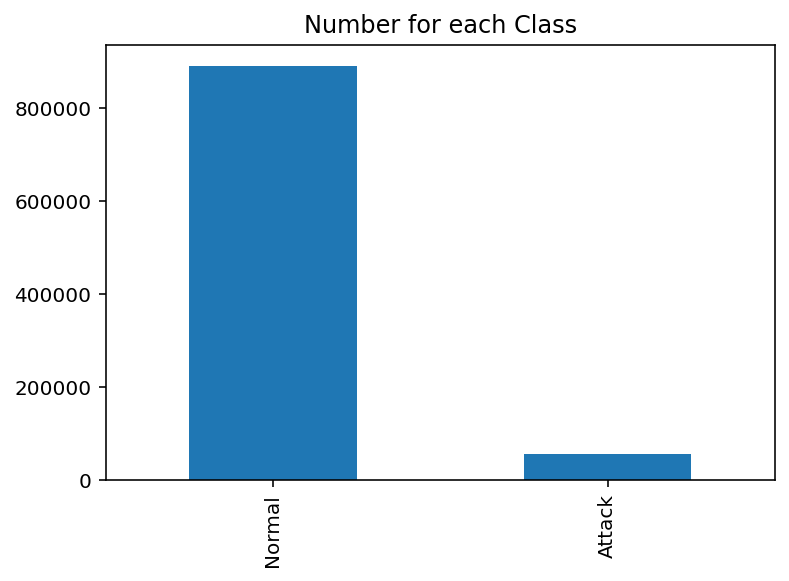

In [11]:
swat["Normal/Attack"].value_counts().plot(kind='bar',
                                    title="Number for each Class")

In [12]:
print(f"There are {np.round(sum(swat['Normal/Attack'] == 'Attack')*100/ len(swat),2)} % attack class from total data")

There are 5.77 % attack class from total data


### data spliting
use 60%  of total data to train model, 10% for validation

In [13]:
x = swat.drop(columns=["Normal/Attack","Timestamp"])
y = swat.drop(np.arange(16000))["Normal/Attack"]

In [14]:
y = pd.DataFrame(
    le.transform(y),
    index = y.index,
    columns= ["label"],
    dtype=float
)

In [15]:
le.classes_ # attack 0, normal 1

array(['Attack', 'Normal'], dtype=object)

In [16]:
# drop unsteady state operation
x.drop(np.arange(16000),inplace=True)

In [17]:
#normalise data into range 0 - 1
scaler = MinMaxScaler()
scaler = scaler.fit(x)

In [18]:
x_scale = pd.DataFrame(
    scaler.transform(x),
    index = x.index,
    columns= x.columns
)

In [19]:
train_idx = int(len(x_scale)*0.6)
val_idx = int(len(x_scale)*0.7)
x_train_data = x_scale[:train_idx]
y_train_data = y[:train_idx]

x_val_data = x_scale[train_idx:val_idx]
y_val_data = y[train_idx:val_idx]

x_test_data = x_scale[val_idx:-1]
y_test_data = y[val_idx:-1]


In [20]:
print(f"There are {sum(y[:train_idx].label == 0)*100/len(y)} % attack data in training set")
print(f"There are {sum(y[train_idx:val_idx].label == 0)*100/len(y)} % attack data in validation set")

There are 0.5573110681097088 % attack data in training set
There are 0.4504044722413532 % attack data in validation set


In [21]:
#convert to sequence
def sequences_convert(input_data ,labels , sequence_length):
    seqs = []
    data_size = len(input_data)
    
    for i in tqdm(range(data_size-sequence_length)):
        
        seq = input_data[i:i+sequence_length]

        label = labels.iloc[i+sequence_length]

        
        seqs.append((seq,label))
    
    return seqs



In [22]:
sequence_length = 200
train_seq = sequences_convert(x_train_data,y_train_data,sequence_length)
val_seq = sequences_convert(x_val_data,y_val_data,sequence_length)
test_seq = sequences_convert(x_test_data,y_test_data,sequence_length)

  0%|          | 0/558231 [00:00<?, ?it/s]

  0%|          | 0/92872 [00:00<?, ?it/s]

  0%|          | 0/279015 [00:00<?, ?it/s]

In [23]:
len(train_seq), len(test_seq)

(558231, 279015)

In [24]:
len(x_train_data),len(x_test_data)

(558431, 279215)

In [25]:
train_seq[0]

(       FIT101    LIT101  MV101  P101  P102    AIT201    AIT202    AIT203  \
 16000     0.0  0.721248    0.5   1.0   0.0  0.902484  0.796586  0.609849   
 16001     0.0  0.720553    0.5   1.0   0.0  0.902484  0.796586  0.609849   
 16002     0.0  0.720287    0.5   1.0   0.0  0.902484  0.796586  0.609668   
 16003     0.0  0.718952    0.5   1.0   0.0  0.902484  0.796586  0.609122   
 16004     0.0  0.717617    0.5   1.0   0.0  0.902484  0.796586  0.608941   
 ...       ...       ...    ...   ...   ...       ...       ...       ...   
 16195     0.0  0.590228    0.5   1.0   0.0  0.902484  0.795406  0.571234   
 16196     0.0  0.589908    0.5   1.0   0.0  0.902484  0.795406  0.571234   
 16197     0.0  0.589534    0.5   1.0   0.0  0.902484  0.795406  0.571234   
 16198     0.0  0.588787    0.5   1.0   0.0  0.902484  0.795406  0.571234   
 16199     0.0  0.588253    0.5   1.0   0.0  0.902484  0.795406  0.570598   
 
          FIT201  MV201  ...    FIT504  P501  P502    PIT501    PIT502  \


In [26]:
n_features = len(x_scale.columns)
n_class = len(le.classes_)

### Over sampling attack label in trainning data


note: using SMOTE resulted in terminal crash

In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy='minority')
# X_sm, y_sm = smote.fit_resample(X_train_seq, Y_train_seq)

# y_sm.value_counts()

In [27]:
# from gsmote import GeometricSMOTE
# gsmote = GeometricSMOTE(
#     k_neighbors=1,
#     deformation_factor=0.0,
#     selection_strategy='minority')

In [28]:
# X_train_seq = [a[0].to_numpy() for a in train_seq]
# Y_train_seq = [a[1].to_numpy() for a in train_seq]

In [ ]:
# data_resampled, targets_resampled = gsmote.fit_resample(X_train_seq, Y_train_seq)

In [27]:
class_0 = []
class_1 = []
for a in train_seq:
  if (a[1].to_numpy() == 0) :
    class_0.append(a)
    # print(f'class_0 {a[1]}')
  else:
    class_1.append(a)

In [28]:
len(class_0), len(class_1)

(5187, 553044)

In [29]:
import random
class_0_over = random.choices(class_0, k=len(class_1))

In [30]:
len(class_0_over), len(class_1)

(553044, 553044)

In [31]:
train_seq_over = class_1+class_0_over

## PyTorch Dataset

In [32]:
class SWaTDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequences, label = self.sequences[idx]
        return dict(
        sequences = torch.Tensor(sequences.to_numpy()),
            label = torch.tensor(label).float()
        )

In [33]:
class SWaTDataModule(pl.LightningDataModule):
    
    def __init__(self,train_seq,val_seq,batch_size):
        super().__init__()
        self.train_seq = train_seq
        self.val_seq = val_seq
        self.test_seq = val_seq
        self.batch_size = batch_size
        
    def setup(self,stage = None):
        self.train_dataset = SWaTDataset(self.train_seq)
        self.val_dataset = SWaTDataset(self.val_seq)
        self.test_dataset = SWaTDataset(self.test_seq)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  

In [33]:
class SWaTDataKFoldModule(pl.LightningDataModule):
    
    def __init__(self,train_seq,
                 n_splits: int = 5,
                 k: int = 1, 
                 batch_size: int = 64):
        super().__init__()

        self.train_seq = train_seq
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.k = k
        assert 1 <= self.k <= self.n_splits, "incorrect fold number"
        
    def setup(self,stage = None):
        kf = KFold(n_splits=self.n_splits, shuffle=False)
        all_splits = [k for k in kf.split(self.train_seq)]
        train_indexes, val_indexes = all_splits[self.k]
        train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

        self.train_dataset = SWaTDataset(self.train_seq[train_indexes[0]:train_indexes[-1]+1])
        self.val_dataset = SWaTDataset(self.train_seq[val_indexes[0]:val_indexes[-1]+1])

        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  
    
    # def test_dataloader(self):
    #     return DataLoader(
    #         self.test_dataset,
    #         batch_size=self.batch_size,
    #         shuffle=False,
    #         num_workers=cpu_count()
    #     )  

In [34]:
n_epochs = 100
batch_size = 200
n_splits = 5

data_module = SWaTDataModule(train_seq_over,val_seq,batch_size)

# data_module = SWaTDataKFoldModule(train_seq,n_splits,k=1,batch_size= batch_size)

## Build LSTM Model

In [35]:
class LSTMModel(nn.Module):
    
    def __init__(self,n_features,n_class,n_hidden=128,n_layers=3):
        super().__init__()
        
        
        self.lstm = nn.LSTM(input_size = n_features,
                            hidden_size = n_hidden,
                            num_layers = n_layers, batch_first = True, 
                            dropout = 0.4)
        
        self.classifier = nn.Linear(n_hidden,  1)
        
    def forward(self,x):
        # print(f"forward of {self.__class__}")
        self.lstm.flatten_parameters()
        
        out,_ = self.lstm(x)
        # print(f"LSTMModel out before classify {out.shape}")

        out = self.classifier(out[:, -1, :])

        # print(f"LSTMModel out {out}")
  
        return out

In [36]:
# data_module
# train_loader = (data_module.train_dataloader())
# for test_data in train_loader:
#   # breakpoint()
#   break

### training and validation loop

In [36]:
class SWaTPredictor(pl.LightningModule):
    
    def __init__(self, n_features:int, learning_rate,n_class):
        super().__init__()
        self.model = LSTMModel(n_features,n_class)
        self.criterion = nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate
    
    def forward(self,x,label=None):
        # print(f"forward of {self.__class__}")
        output = self.model(x)
        loss = 0
        # print("output",output.type(torch.LongTensor).shape)
        # print("label",label.shape)
        if label is not None:
          output_long = output.long()
          # print(f"output_long={output_long.shape}")
          # print(f"output={output.shape}")
          loss = self.criterion(output,  label)
        return loss, output
    
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)
        preds =  torch.round(torch.sigmoid(outputs))
        step_accuracy = accuracy(preds,torch.flatten(labels).int())

        self.log("train_accuracy", step_accuracy, prog_bar = True, logger=True)
        self.log("train_loss", loss, prog_bar = True, logger=True)
        return {"loss":loss, "accuracy":step_accuracy}
    
    def training_epoch_end(self, outs):
        loss = sum(output['loss'] for output in outs) / len(outs)
        accuracy = sum(output['accuracy'] for output in outs) / len(outs)
        self.log('train_loss_epoch', loss)
        self.log('train_acc_epoch', accuracy)

        
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)
        preds =  torch.round(torch.sigmoid(outputs))
        # print("labels",torch.flatten(labels))
        # print("preds",preds)
        step_accuracy = accuracy(preds,torch.flatten(labels).int())
        # print("step_accuracy",step_accuracy)
        self.log("val_accuracy", step_accuracy, prog_bar = True, logger=True)
        self.log("val_loss", loss, prog_bar = True, logger=True)
        return {"loss":loss,"accuracy":step_accuracy}

    def validation_epoch_end(self, outs):
        loss = sum(output['loss'] for output in outs) / len(outs)
        accuracy = sum(output['accuracy'] for output in outs) / len(outs)
        self.log('val_loss_epoch', loss)
        self.log('val_acc_epoch', accuracy)

    def test_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)
        preds =  torch.round(torch.sigmoid(outputs))
        step_accuracy = accuracy(preds,torch.flatten(labels).int())
        
        self.log("test_accuracy", step_accuracy, prog_bar = True, logger=True)
        self.log("test_loss", loss, prog_bar = True, logger=True)
        return {"loss":loss,"accuracy":step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr= self.learning_rate)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Data_sci_Project/logs_blackbox

In [46]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/Data_sci_Project/checkpoints_blackbox",
    filename = "best-checkpoint",
    save_top_k =1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("/content/drive/MyDrive/Data_sci_Project/logs_blackbox",name = "swat")
# logger=CSVLogger(save_dir="logs/")

early_stopping_callback = EarlyStopping(monitor = "val_loss", patience=4)

trainer = pl.Trainer(logger= logger, auto_lr_find=True,
                     checkpoint_callback = checkpoint_callback,
                     max_epochs=n_epochs, 
                     gpus=1,
                     callbacks = [early_stopping_callback],
                     progress_bar_refresh_rate=30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /content/drive/MyDrive/Data_sci_Project/checkpoints_blackbox exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [39]:
learning_rate = 0.001

In [40]:
model = SWaTPredictor(
    n_features= n_features,n_class=n_class,learning_rate = learning_rate)

In [54]:
test_model = SWaTPredictor(
    n_features= 1,n_class=1,learning_rate = learning_rate)

In [ ]:
a = torch.rand((5,1))

In [ ]:
a

In [ ]:
_, re = test_model(a, a)

In [ ]:
torch.sigmoid(re)

In [81]:
# model(torch.rand((10, 200, 51)), torch.rand((10, 1)))

In [43]:
# test_data['sequences'].shape, test_data['label'].shape

In [44]:
# %debug

In [47]:
#tuning lr
lr_finder = trainer.tuner.lr_find(model,data_module)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | LSTMModel         | 356 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.428     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


In [46]:
# %debug

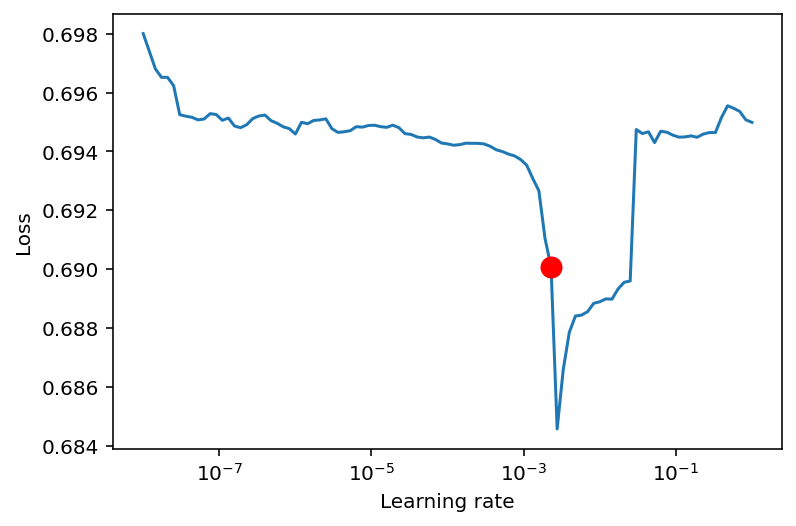

In [49]:
fig = lr_finder.plot(suggest=True) # Plot
fig.show()

In [50]:
model.hparams.lr = lr_finder.suggestion()

In [51]:
learning_rate = lr_finder.suggestion()

In [52]:
print(model)

SWaTPredictor(
  (model): LSTMModel(
    (lstm): LSTM(51, 128, num_layers=3, batch_first=True, dropout=0.4)
    (classifier): Linear(in_features=128, out_features=1, bias=True)
  )
  (criterion): BCEWithLogitsLoss()
)


### train model with KFold CV

In [53]:
# for k in range(1,n_splits):
#   data_module = SWaTDataKFoldModule(train_seq,n_splits = n_splits,k=k,batch_size= batch_size)

#   # Folder hack
#   logger = TensorBoardLogger(save_dir="/content/drive/MyDrive/Data_sci_Project/logs_blackbox/kfold",name = f'swat_fold{k+1}')
#   checkpoint_callback = ModelCheckpoint(
#     dirpath = "/content/drive/MyDrive/Data_sci_Project/checkpoints_blackbox/kfold",
#     filename = "best-checkpoint",
#     save_top_k =1,
#     verbose = True,
#     monitor = "val_loss",
#     mode = "max")
#   early_stopping_callback = EarlyStopping(monitor = "val_loss", patience=4)
#   trainer = pl.Trainer(logger= logger, auto_lr_find=True,
#                      checkpoint_callback = checkpoint_callback,
#                      max_epochs=n_epochs, 
#                      gpus=1,
#                      callbacks = [early_stopping_callback],
#                      progress_bar_refresh_rate=30)

#   model = SWaTPredictor(
#     n_features= n_features,n_class=n_class,learning_rate = learning_rate)
#   trainer.fit(model, data_module)



GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | model     | LSTMModel         | 356 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.428     Total estimated model params size (MB)
INFO:lightning:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | LSTMModel         | 356 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.428     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


MisconfigurationException: ignored

### Train model

In [53]:
trainer.fit(model, data_module)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | LSTMModel         | 356 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.428     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 1, global step 5531: val_loss reached 0.60142 (best 0.60142), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints_blackbox/best-checkpoint-v14.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 11062: val_loss reached 0.50460 (best 0.50460), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints_blackbox/best-checkpoint-v14.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, step 16593: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, step 22124: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, step 27655: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, step 33186: val_loss was not in top 1


1

In [106]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.0,
 'loss': 1.5355559587478638,
 'test_accuracy': 0.04513739421963692,
 'test_loss': 1.4771907329559326}
--------------------------------------------------------------------------------


[{'accuracy': 0.0,
  'loss': 1.5355559587478638,
  'test_accuracy': 0.04513739421963692,
  'test_loss': 1.4771907329559326}]

In [64]:
train_model = SWaTPredictor.load_from_checkpoint(
   trainer.checkpoint_callback.best_model_path,n_class = n_class,
    n_features = n_features,learning_rate = learning_rate)

train_model.freeze()

### tuning prediction threshold

In [65]:
val_dataset = DataLoader(SWaTDataset(val_seq),batch_size=batch_size)

In [ ]:
val_prob = []
val_labbels = []

for item in tqdm(val_dataset):
  sequences = item["sequences"]
  label = item["label"]
  # attack = item["attack"]
  # print(sequences.shape)

  _, output = train_model(sequences)
  # print(f"output {output}")
  # print(f"torch.sigmoid(output) {torch.sigmoid(output)}")
  val_prob.append(torch.sigmoid(output))
  val_labbels.append(label.float())

  0%|          | 0/465 [00:00<?, ?it/s]

In [ ]:
y_val = [t.detach().numpy() for t in val_labbels]
val_probs = [t.detach().numpy() for t in val_prob]

In [ ]:
from itertools import chain

In [ ]:
y_val =  np.array(list(chain.from_iterable(y_val))).flatten()
val_probs = np.array(list(chain.from_iterable(val_probs))).flatten()

In [121]:
thresholds = np.round(np.arange(0.05,0.95,0.05),2)
threshold1 = ghostml.optimize_threshold_from_predictions(y_val, val_probs, thresholds, ThOpt_metrics = 'ROC') 

In [123]:
def calc_metrics(labels_test, test_probs, threshold):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return 

In [124]:
calc_metrics(y_val, val_probs, threshold = threshold1)

thresh: 0.05, kappa: 0.000, AUC test-set: 0.500
[[    0  4192]
 [    0 88680]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4192
         1.0       0.95      1.00      0.98     88680

    accuracy                           0.95     92872
   macro avg       0.48      0.50      0.49     92872
weighted avg       0.91      0.95      0.93     92872



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
# %debug

###Predict on test sequences

In [ ]:
test_dataset = DataLoader(SWaTDataset(test_seq),batch_size=batch_size)

In [ ]:
prediction = []
labbels = []

for item in tqdm(test_dataset):
  sequences = item["sequences"]
  label = item["label"]
  # attack = item["attack"]
  # print(sequences.shape)

  _, output = train_model(sequences)
  # print(output)
  prediction.append(torch.round(torch.sigmoid(output)))
  labbels.append(label.float())

  0%|          | 0/4360 [00:00<?, ?it/s]

In [ ]:
a = [t.numpy() for t in prediction]
c = [t.numpy() for t in labbels]

In [ ]:
flatten_pred = list(chain.from_iterable(a))
flatten_lab = list(chain.from_iterable(c))

In [ ]:
b = np.array(flatten_pred).flatten()
d = np.array(flatten_lab).flatten()

In [ ]:
print(classification_report(b,d))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.84      0.91    279015

    accuracy                           0.84    279015
   macro avg       0.50      0.42      0.46    279015
weighted avg       1.00      0.84      0.91    279015



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sum(b == 1)

279015

In [ ]:
sum(b == 0)

0